In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
recordings = os.listdir("Recordings/training")

In [3]:
df = pd.DataFrame()
df["filenames"] = recordings
df["labels"] = [recording.split('.')[0] for recording in recordings]
df["mapped_labels"] = df["labels"].map({"Apple":0, "Cherry":1, "Orange":2, "Unknown":3})

In [4]:
print(df)
df.to_csv("labels.csv")

                                             filenames   labels  mapped_labels
0     Apple.5kh0pmfj.ingestion-8474d8fb45-pdwsh.s5.wav    Apple              0
1    Cherry.5kh1qkbd.ingestion-8474d8fb45-9wskt.s5.wav   Cherry              1
2     Apple.5kh0cn3e.ingestion-8474d8fb45-9wskt.s1.wav    Apple              0
3    Cherry.5kh2800p.ingestion-8474d8fb45-6skpk.s8.wav   Cherry              1
4    Cherry.5kh21qib.ingestion-8474d8fb45-pdwsh.s4.wav   Cherry              1
..                                                 ...      ...            ...
235  Orange.5kh3h8ol.ingestion-8474d8fb45-6skpk.s8.wav   Orange              2
236  Orange.5kh48ndd.ingestion-8474d8fb45-pdwsh.s4.wav   Orange              2
237  Orange.5kh32m5q.ingestion-8474d8fb45-9wskt.s7.wav   Orange              2
238   Apple.5kh10n2n.ingestion-8474d8fb45-pdwsh.s5.wav    Apple              0
239  Unknown.5kh4s5kb.ingestion-8474d8fb45-pdwsh.s4...  Unknown              3

[240 rows x 3 columns]


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split

import torchaudio
from torchaudio import datasets
from torchaudio import transforms as T
from torchaudio import models
from torchaudio import pipelines
import torchaudio.functional as AF

from torch.nn.utils.rnn import pad_sequence

import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from torchmetrics import Accuracy
from sklearn.model_selection import train_test_split
import librosa
from tqdm import tqdm

from IPython.display import Audio

In [6]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [7]:
def num_params(model):
  nums = sum(p.numel() for p in model.parameters())/1e6
  return nums

In [8]:
def print_stats(waveform, sample_rate=None, src=None):
    if src:
        print("-" * 10)
        print("Source:", src)
        print("-" * 10)
    if sample_rate:
        print("Sample Rate:", sample_rate)
    print("Shape:", tuple(waveform.shape))
    print("Dtype:", waveform.dtype)
    print(f" - Max:     {waveform.max().item():6.3f}")
    print(f" - Min:     {waveform.min().item():6.3f}")
    print(f" - Mean:    {waveform.mean().item():6.3f}")
    print(f" - Std Dev: {waveform.std().item():6.3f}")
    print()
    print(waveform)
    print()

In [9]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
        if ylim:
            axes[c].set_ylim(ylim)
    figure.suptitle(title)
    plt.show(block=False)

In [10]:
def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(T.AmplitudeToDB()(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

In [11]:
test_audio:str = "Recordings/training/Apple.5kgvrcdv.ingestion-8474d8fb45-9wskt.s1.wav"
Audio(test_audio)

In [12]:
metadata = torchaudio.info(test_audio)
print(metadata)

AudioMetaData(sample_rate=16000, num_frames=48000, num_channels=1, bits_per_sample=16, encoding=PCM_S)


Sample Rate: 16000
Shape: (1, 48000)
Dtype: torch.float32
 - Max:      0.275
 - Min:     -0.229
 - Mean:    -0.002
 - Std Dev:  0.014

tensor([[-0.0112, -0.0111, -0.0111,  ...,  0.0001,  0.0002,  0.0003]])



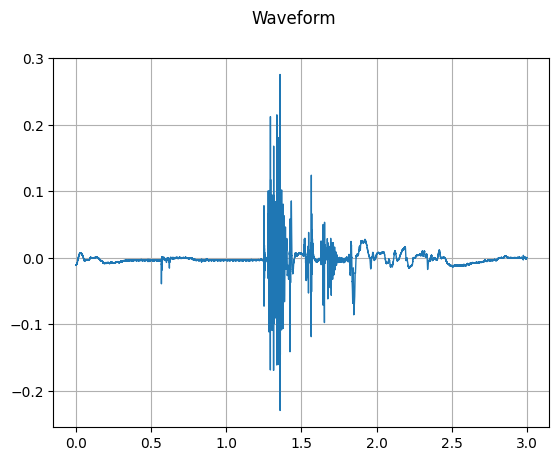

In [13]:
waveform, sample_rate = torchaudio.load(test_audio)
print_stats(waveform, sample_rate)
plot_waveform(waveform, sample_rate)

tensor([[-0.0112, -0.0111, -0.0111,  ...,  0.0001,  0.0002,  0.0003]])
Sample Rate: 16000
Shape: (1, 48000)
Dtype: torch.float32
 - Max:      0.275
 - Min:     -0.229
 - Mean:    -0.002
 - Std Dev:  0.014

tensor([[-0.0112, -0.0111, -0.0111,  ...,  0.0001,  0.0002,  0.0003]])



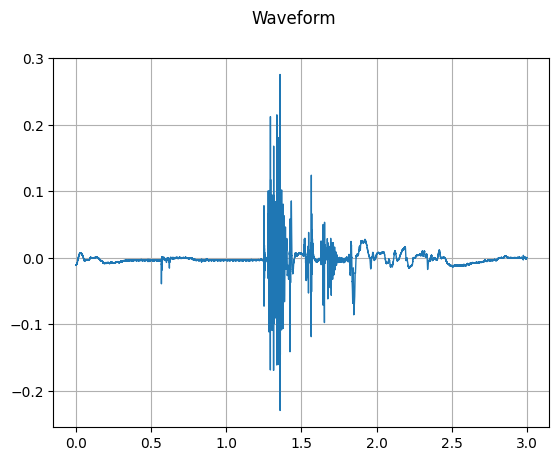

In [14]:
waveform2 = waveform.mean(dim=0, keepdim=True)
print(waveform2)
print_stats(waveform2, sample_rate)
plot_waveform(waveform2, sample_rate)
Audio(waveform2.numpy(), rate=sample_rate)

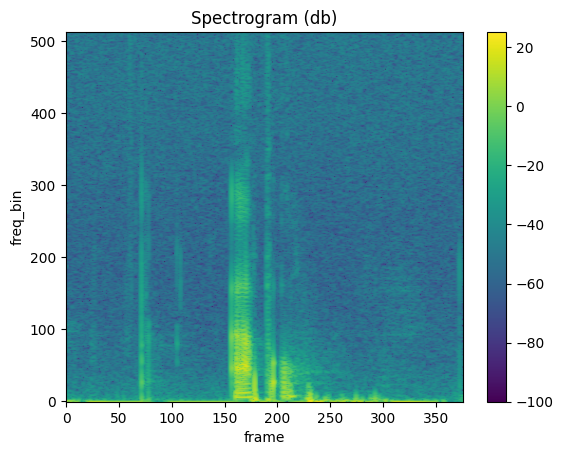

In [15]:
spectrogram = T.Spectrogram(n_fft=1024, hop_length=128)
spec = spectrogram(waveform)
plot_spectrogram(spec[0])

In [16]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return x

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [18]:
print(device)

cpu


In [19]:
model = M5(n_input=1, n_output=4)
model.to(device)

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=4, bias=True)
)

In [20]:
num_params(model)

0.0249

In [21]:
from torchmetrics import Accuracy
def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch=None):
  model.train()
  loss_train = AverageMeter()
  acc_train = Accuracy(task="multiclass", num_classes=4).to(device)
  with tqdm(train_loader, unit="batch") as tepoch:
    for inputs, targets in tepoch:
      if epoch is not None:
        tepoch.set_description(f"Epoch {epoch}")
      inputs = inputs.to(device)
      targets = targets.to(device)
      outputs = model(inputs)
      outputs = outputs[:,0,:]
      loss = loss_fn(outputs, targets)

      loss.backward()

      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item())
      acc_train(outputs, targets.int())
      tepoch.set_postfix(loss=loss_train.avg,
                         accuracy=100.*acc_train.compute().item())
  return model, loss_train.avg, acc_train.compute().item()

In [22]:
def validation(model, test_loader, loss_fn):
  model.eval()
  with torch.no_grad():
    loss_valid = AverageMeter()
    acc_valid = Accuracy(task="multiclass", num_classes=4).to(device)
    for i, (inputs, targets) in enumerate(test_loader):
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      outputs = outputs[:,0,:]
      loss = loss_fn(outputs, targets)

      loss_valid.update(loss.item())
      acc_valid(outputs, targets.int())
  return loss_valid.avg, acc_valid.compute().item()

In [23]:
result = torchaudio.load(test_audio)
print(result)

(tensor([[-0.0112, -0.0111, -0.0111,  ...,  0.0001,  0.0002,  0.0003]]), 16000)


In [24]:
from torch.utils.data import Dataset
#Creating a dataset class for the audio data
class AudioDataset(Dataset):
    def __init__(self, label_file, file_dir):
        self.df = pd.read_csv(label_file)
        self.labels = df["mapped_labels"]
        self.file_names = df["filenames"]
        self.file_dir = file_dir
    
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        file_path = os.path.join(self.file_dir, self.file_names[index])
        waveform = torchaudio.load(file_path)[0]
        label = self.labels[index]
        return waveform, label



In [25]:
dataset = AudioDataset("labels.csv", "Recordings/training/")

In [26]:
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
len(train_loader)

8

In [27]:
model = M5(n_input=1, n_output=4).to(device)
loss_fn = nn.CrossEntropyLoss()

x_batch, y_batch = next(iter(train_loader))
print(x_batch)
outputs = model(x_batch.to(device)).reshape(32,4)
loss = loss_fn(outputs, y_batch.to(device))
print(loss)

tensor([[[-2.1057e-02, -2.5269e-02, -2.9572e-02,  ..., -3.3569e-04,
          -1.2207e-04, -3.0518e-05]],

        [[-3.0212e-03, -3.0823e-03, -3.0212e-03,  ..., -2.4414e-04,
          -2.4414e-04, -2.4414e-04]],

        [[-2.3193e-03, -2.2583e-03, -2.1057e-03,  ..., -1.1597e-03,
          -1.0986e-03, -1.1597e-03]],

        ...,

        [[-3.4485e-03, -3.7231e-03, -3.5095e-03,  ..., -3.9368e-03,
          -3.9062e-03, -4.2114e-03]],

        [[-2.6550e-03, -2.4719e-03, -2.5330e-03,  ..., -2.8687e-03,
          -3.0518e-03, -2.8687e-03]],

        [[-2.5024e-03, -2.0142e-03, -2.1362e-03,  ..., -1.2207e-03,
          -2.0447e-03, -1.6785e-03]]])
tensor(1.3628, grad_fn=<NllLossBackward0>)


In [28]:
from torch.utils.data import random_split
train, test = random_split(dataset, [0.8,0.2])
training_loader = DataLoader(train, batch_size=32, shuffle=True)
test_loader = DataLoader(test, batch_size=32, shuffle=False)
_, mini_train_dataset = random_split(train,
                                     (len(train)-150, 150))
mini_train_loader = DataLoader(mini_train_dataset, 30)

In [29]:
model = M5(n_input=1, n_output=4).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
# defining Cross-Entropy loss
criterion = torch.nn.CrossEntropyLoss()
train_one_epoch(model, train_loader, criterion, optimizer )

100%|██████████| 8/8 [00:01<00:00,  4.29batch/s, accuracy=53.8, loss=1.27]


(M5(
   (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
   (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
   (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
   (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
   (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
   (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
   (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
   (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
   (fc1): Linear(in_features=64, out_features=4, bias=

In [30]:
num_epochs = 50
for epoch in range(num_epochs):
  model, _, _ = train_one_epoch(model, train_loader, criterion, optimizer, epoch)

Epoch 49: 100%|██████████| 8/8 [00:01<00:00,  4.34batch/s, accuracy=100, loss=0.0078] 


In [32]:
val_loss , val_acc = validation(model, test_loader, criterion)
print(f"Loss on test sample: {val_loss}")
print(F"Accuracy on test sample: {val_acc}")

Loss on test sample: 0.005823633400723338
Accuracy on test sample: 1.0


In [34]:
#Starting on an image recognition task
import torchvision

In [35]:
cifar_training_data = torchvision.datasets.CIFAR10(root="./data", train=True, download=True)
cifar_test_data = torchvision.datasets.CIFAR10(root="./data", train=False, download=True)

100%|██████████| 170M/170M [00:24<00:00, 6.85MB/s] 


9


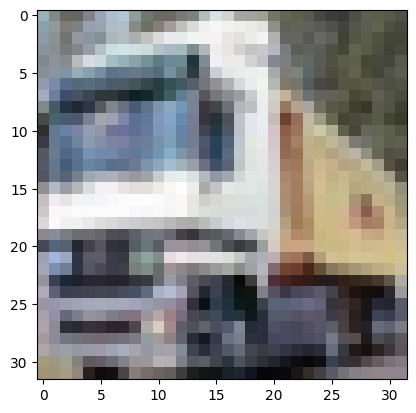

In [37]:
image, label = cifar_training_data[1]
plt.imshow(image)
print(label)

In [38]:
from torchvision.transforms import ToTensor 
cifar_training_data = torchvision.datasets.CIFAR10(root="./data", train=True, transform=ToTensor())
cifar_test_data = torchvision.datasets.CIFAR10(root="./data", train=False, transform=ToTensor())

In [39]:
batch_size = 64

train_dataloader = DataLoader(cifar_training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(cifar_test_data, batch_size=batch_size, shuffle=True)

In [40]:
for image, labels in train_dataloader:
    print(labels.shape)
    print(image.shape)
    break

torch.Size([64])
torch.Size([64, 3, 32, 32])


In [41]:
classes = ("planes", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

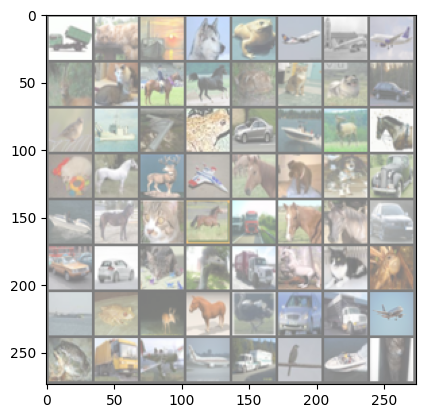

truckcat  ship dog  frog planesplanesplanesdeer cat  horsehorsedeer cat  dog  car  bird ship planesfrog car  ship deer horsedog  horsedeer planeshorsedog  dog  car  ship horsecat  horsetruckhorsehorsecar  car  car  cat  bird truckhorsecat  frog ship frog deer horsebird car  truckplanesfrog truckplanesplanestruckbird ship cat  


In [44]:
def imshow(img):
    img = img/2+0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

dataiter = iter(train_dataloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(''.join(f'{classes[labels[j]]:5s}' for j in range(64)))



In [45]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,6,5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [46]:
criterion = nn.HingeEmbeddingLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)